# Analysis of Summary Motility Metrics in Pools
---

#### Overview

This notebook utilizes the summary motility metrics computed from individual cell trajectories (generated in [`1_compute-summary-motility-metrics.ipynb`](./1_compute-summary-motility-metrics.ipynb)) to explore the effects of certain experimental variables on motility.

The experimental variables explored here include the amount of time the cells spent in water prior to imaging and the position in the tube the cells were extracted from. To better understand why these experimental variables were chosen and the parameter space they encompass, please refer to Figure 1 of the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

For each experimental variable, we generate univariate kernel density estimate plots for several motility metrics to draw comparisons between e.g. motility of cells that spent 4 hours in water vs those that spent 21 hours in water prior to imaging. We then plot joint distributions to enable the same comparisons between experimental variables but for two separate motility metrics simultaneously.

Output from this notebook was used to generate Figure 5 and Figure 6 in the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

In [1]:
import string
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chlamytracker.utils import annotate_statistical_significance

Configure matplotlib styles to match the Arcadia style guide

In [2]:
import arcadia_pycolor as apc

apc.mpl.setup()

## Load Motility Metrics
---

Load summary motility metrics from all cells swimming in pools generated in [`1_compute-summary-motility-metrics.ipynb`](./1_compute-summary-motility-metrics.ipynb).

#### Collect csv files

In [3]:
# read csv
csv_file = Path("../data/AMID-04_summary_motility_metrics.csv")
motility_metrics_dataframe = pd.read_csv(csv_file)

# preview
motility_metrics_dataframe.drop(["slide_ID", "well_ID"], axis=1).groupby(
    ["position_in_tube", "time_in_water"]
).head(2)

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,experiment_ID,strain,vessel_type,position_in_tube,time_in_water,timelapse_ID,pool_ID
0,14.60292,723.059408,51.339131,22.719548,0.071003,49.514714,3.515676,3.595302,0.0,33,0.045639,1,AMID-04,cc124,pools,top,21,1,2x0
1,10.10202,420.157509,91.028098,16.674224,0.216652,41.591435,9.010881,3.086678,0.0,17,0.040461,1,AMID-04,cc124,pools,top,21,1,3x0
83,12.55251,194.253793,17.959306,6.741264,0.092453,15.475295,1.430734,3.626716,2.0,31,0.159585,1,AMID-04,cc124,pools,middle,21,4,0x0
84,19.95399,449.436363,53.439939,9.120043,0.118904,22.523634,2.678158,5.417029,1.0,57,0.126826,1,AMID-04,cc124,pools,middle,21,4,2x3
119,15.05301,453.167671,78.331209,13.325166,0.172853,30.104788,5.203691,4.866694,4.0,47,0.103714,1,AMID-04,cc124,pools,top,4,1,3x0
120,19.95399,208.840261,8.935551,4.954940,0.042787,10.466090,0.447808,5.191020,7.0,68,0.325608,1,AMID-04,cc124,pools,top,4,3,2x1
141,19.90398,423.901283,49.489268,7.501952,0.116747,21.297313,2.486401,2.241343,1.0,24,0.056617,1,AMID-04,cc124,pools,middle,4,2,2x1
142,14.25285,401.621388,28.424880,12.219971,0.070775,28.178321,1.994330,4.432062,2.0,44,0.109556,1,AMID-04,cc124,pools,middle,4,8,4x2


## 1D Analysis
---

#### Experimental parameters
Experimental parameters to analyze.

| strain  | vessel         | position in tube | time in water |
|---------|----------------|------------------|---------------|
| cc124   | pools          | top              | 4 hrs         |
|         |                | middle           | 21 hrs        |

In [4]:
# set metrics
metrics_subset = [
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_angular_speed",
]

# set experimental variables
experimental_variables = [
    "position_in_tube",
    "time_in_water",
]

# set color palettes in accordance with experimental variables
palettes = {
    "time_in_water": ["#73B5E3", "#377BB7"],
    "position_in_tube": ["#B5BEA4", "#596F74"],
    "vessel": ["#F28360", "#7A77AB"],
}

#### Univariate distributions

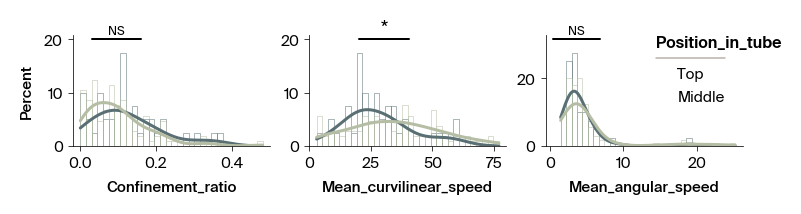

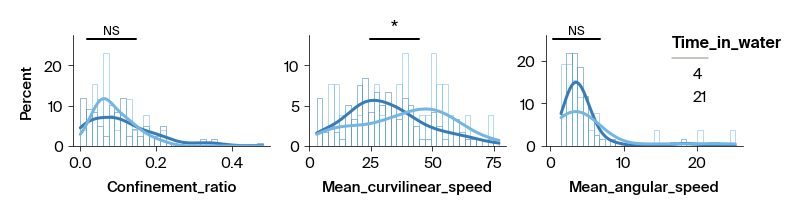

In [5]:
# loop through experimental variables
for k, experimental_variable in enumerate(experimental_variables):
    # create figure
    ncols = len(metrics_subset)
    fig, axes = plt.subplots(
        ncols=ncols,
        figsize=(4 * ncols, 2),
    )

    # loop through select metrics
    for i, metric in enumerate(metrics_subset):
        last = len(metrics_subset) - 1
        legend = True if i == last else False
        ylabel = "Percent" if i == 0 else ""

        # render univariate distribution
        g = sns.histplot(
            data=motility_metrics_dataframe,
            x=metric,
            hue=experimental_variable,
            palette=palettes[experimental_variable],
            fill=False,
            kde=True,
            line_kws={"lw": 3},
            bins=32,
            stat="percent",
            common_norm=False,
            legend=legend,
            ax=axes[i],
        )

        # extract distributions from the plot which are separated by `experimental_variable`
        # only works for the case of N = 2 experimental variable values
        experimental_variable_values = motility_metrics_dataframe[experimental_variable].unique()
        distribution_A = motility_metrics_dataframe.loc[
            motility_metrics_dataframe[experimental_variable] == experimental_variable_values[0],
            metric,
        ]
        distribution_B = motility_metrics_dataframe.loc[
            motility_metrics_dataframe[experimental_variable] == experimental_variable_values[1],
            metric,
        ]
        # perform Mann-Whitney U test + annotate statistical significance
        annotate_statistical_significance(distribution_A, distribution_B, axes[i])

        # axis-level aesthetics
        axes[i].set_ylabel(ylabel)
        sns.despine(ax=axes[i])
        if legend:
            sns.move_legend(axes[i], "upper right", bbox_to_anchor=(1.2, 1))
        apc.mpl.style_plot(axes[i])

    # save figure
    panel = string.ascii_uppercase[k]
    plt.savefig(f"../results/figure-5{panel}.svg")

#### Time in water with position in tube fixed (or Position in tube with time in water fixed)

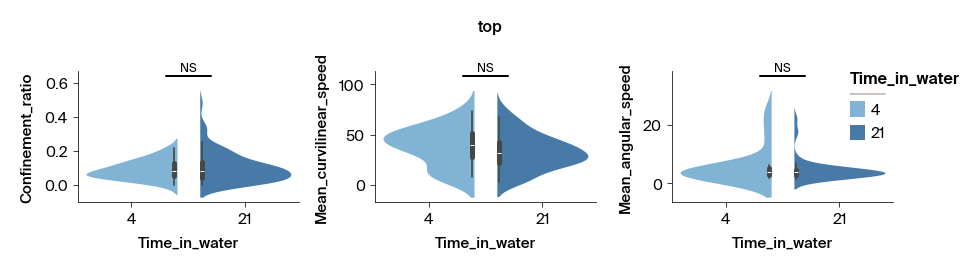

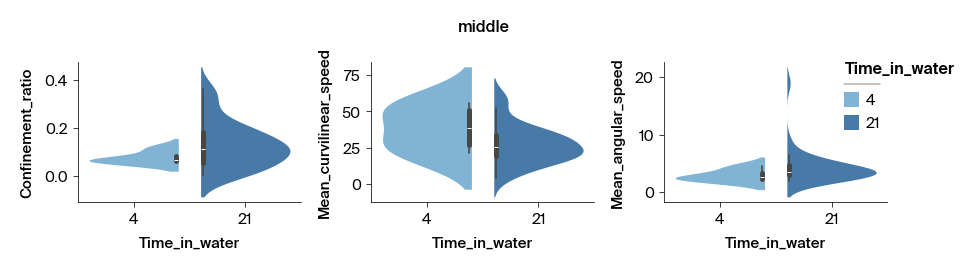

In [6]:
# set experimental variable of interest
experimental_variable = "time_in_water"
# get a list of possible positions in tube: [top, middle]
positions_in_tube = motility_metrics_dataframe["position_in_tube"].unique().tolist()

# loop through experimental variables
# (position in tube and time in water)
for k, position_in_tube in enumerate(positions_in_tube):
    # create figure
    ncols = len(metrics_subset)
    fig, axes = plt.subplots(
        ncols=ncols,
        figsize=(4.5 * ncols, 3.5),
    )

    # filter
    source = motility_metrics_dataframe.loc[
        motility_metrics_dataframe["position_in_tube"] == position_in_tube
    ]

    # loop through select metrics
    for i, metric in enumerate(metrics_subset):
        # only add a legend to the right-most axis
        if i == len(metrics_subset) - 1:
            legend = True
        else:
            legend = False

        # render violin plot
        g = sns.violinplot(
            data=source,
            x=experimental_variable,
            y=metric,
            hue=experimental_variable,
            palette=palettes[experimental_variable],
            inner="box",
            inner_kws={"box_width": 5},
            split=True,
            legend=legend,
            ax=axes[i],
        )

        # extract distributions from the plot which are separated by `experimental_variable`
        experimental_variable_values = source[experimental_variable].unique()
        distribution_A = source.loc[
            source[experimental_variable] == experimental_variable_values[0], metric
        ]
        distribution_B = source.loc[
            source[experimental_variable] == experimental_variable_values[1], metric
        ]
        # perform Mann-Whitney U test + annotate statistical significance
        try:
            annotate_statistical_significance(
                distribution_A, distribution_B, axes[i], center_annotation=True
            )
        except ValueError:
            pass

        # axis-level aesthetics
        sns.despine(ax=axes[i])
        if legend:
            sns.move_legend(axes[i], "upper right", bbox_to_anchor=(1.3, 1))
        apc.mpl.style_plot(axes[i])

    # figure-level aesthetics
    fig.suptitle(position_in_tube)
    plt.tight_layout()
    # save figure
    panel = string.ascii_uppercase[k]
    plt.savefig(f"../results/figure-6{panel}.svg")

## 2D analysis
---

#### Bivariate distributions

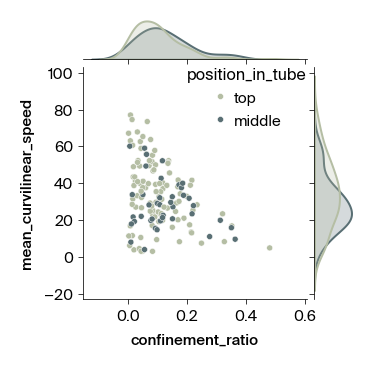

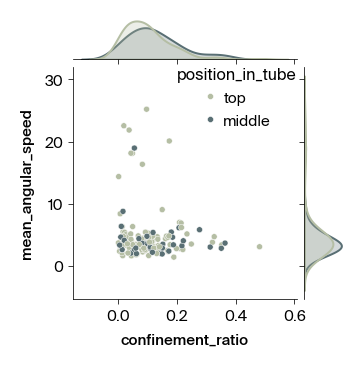

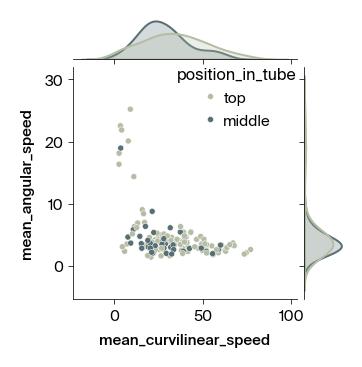

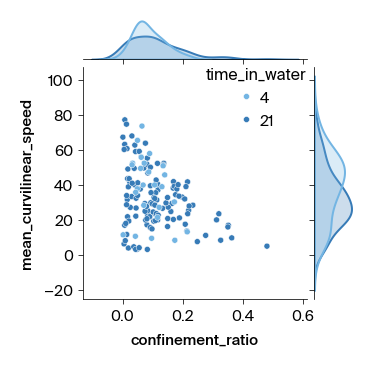

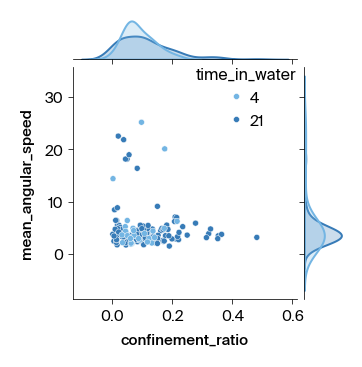

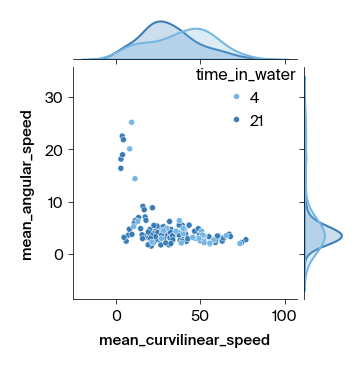

In [7]:
# loop through experimental variables
for variable in experimental_variables:
    # loop through combinations of metrics
    for metric_i, metric_j in combinations(metrics_subset, 2):
        # render joint distribution
        g = sns.JointGrid(
            data=motility_metrics_dataframe,
            x=metric_i,
            y=metric_j,
            hue=variable,
            palette=palettes[variable],
            height=5,
        )

        # aesthetics
        g.plot_joint(sns.scatterplot, legend=True)
        g.plot_marginals(sns.kdeplot, lw=2, fill=True, common_norm=False)